In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
import sensor_lib as sl

/home/jovyan/RQC-Robotics-tactile_sensor


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import yaml

In [33]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
geo = config['env']['sen_geometry']
phys = config['env']['phys']

# generation pressure_map

In [36]:
x = geo['x_len']
y = geo['y_len']
n_pic = config['dataset']['n_sampels']
n_gaus = config['env']['presure_profile']['n_gauses']
size_kof = config['env']['presure_profile']['size_kof']
vec_mat = tf.constant(sl.get_vec_mat(x, y), dtype=tf.float32)
vec_mat = tf.reshape(vec_mat, [-1, 2])
with open(config['env']['presure_profile']['g_param_path'], 'wb+') as f:
    np.save(f, vec_mat)

In [37]:
gaus_data = sl.gen_rand_cof(n_gaus * n_pic, x, y, size_kof)
gaus_data = tf.reshape(gaus_data, [n_pic, n_gaus, 5])
pictures = sl.generate_pictures(gaus_data, vec_mat)
pictures = tf.reshape(pictures, [n_pic, x, y])

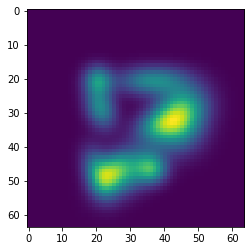

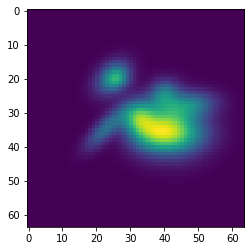

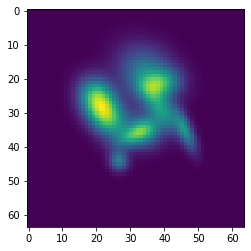

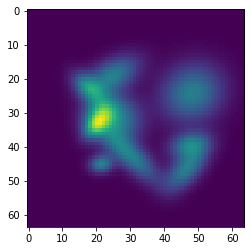

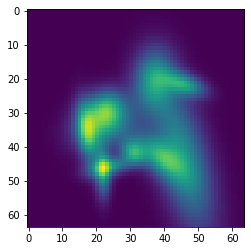

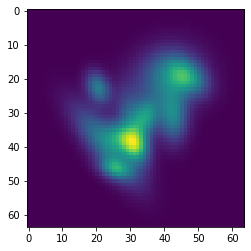

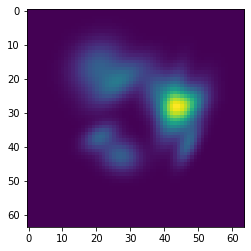

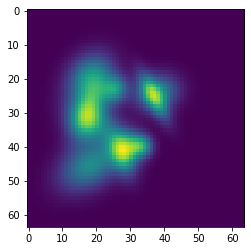

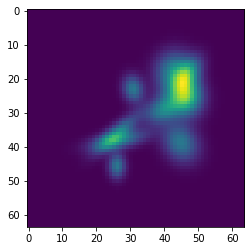

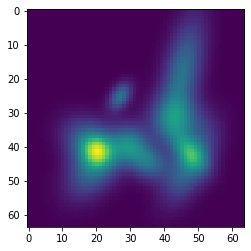

In [38]:
for i in range(10):
    plt.imshow(pictures[i])
    plt.show()

# counting losses in fibers (input of nerual network)

In [ ]:
input, output, input_test, output_test = sl.sim_on_gpu(
    dir_of_data + 'fresh_gauss' + str(n_gauses) + '_' + str(n_pic) + '.npy',
    n_random_rot=n_rot,
    n_angles=n_fibers,
    batch_size_preproc=128 * 8)
input_shape = input.shape
output_shape = output.shape
dataset_b, dataset = sl.prepare_dataset_for_train(input,
                                                  output,
                                                  batch_size_fit_model=1024 * 2)
dataset_test_b, dataset_test = sl.prepare_dataset_for_train(
    input_test, output_test, batch_size_fit_model=1024 * 2)

# defining nerual network for decoding and fitting it

In [ ]:
model = sl.SensorNN4S(input_shape[1:3], output_shape[1:3])
model.build(input_shape)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lerning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model_name = 'deep_model'

In [ ]:
model.fit(dataset_b, epochs=n_epochs, verbose=1)

In [ ]:
model.save(dir_of_data + 'models_weights/model4S_' + str(n_fibers) + 'fi.nn')

# evoluate model on don't seen data

In [ ]:
model = tf.keras.models.load_model(dir_of_data + 'models_weights/model4S_' +
                                   str(n_fibers) + 'fi.nn')

In [ ]:
model.evaluate(dataset_test_b)

In [ ]:
predictions = model.predict(dataset_test_b)
predictions.shape

# saving resalts

In [ ]:
with open(
        dir_of_data + 'results/' + model_name + '_' + str(n_gauses) + 'g_' +
        str(n_fibers) + 'fi', 'wb') as f:
    np.save(f, predictions)
    np.save(f, output_test)

# look on resalts

In [ ]:
with open(
        dir_of_data + 'results/' + model_name + '_' + str(n_gauses) + 'g_' +
        str(n_fibers) + 'fi', 'rb') as f:
    predictions = np.load(f)
    output_test = np.load(f)

In [ ]:
print('len= ', len(predictions))
N = 4  # number of exampel
plt.imshow(predictions[N])
plt.show()
plt.imshow(output_test[N])
plt.show()